In [1]:

from fastcore.basics import store_attr
from fastcore.xtras import Path
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize, ColSplitter, RandomSplitter
from fastai.losses import FocalLossFlat
from fastai.losses import DiceLoss
from fastai.torch_core import tensor
from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats, SegmentationDataLoaders
from fastai.vision.learner import unet_learner
import numpy as np
from torchvision.models.resnet import resnet34
import torch
import torch.nn.functional as F
import boto3
import shutil
from tensorboard import notebook
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
import requests
from fastai.callback.tensorboard import TensorBoardCallback

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

from fastai.callback.tensorboard import TensorBoardCallback


In [3]:
import torch.cuda
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3080


In [4]:
combined_img2 = Path('C:/Users/thomas/Desktop/irdis/AISpark_Challenge_IRDIS-main/AIHub/Training/train_buildings_data2')
combined_mask2 = Path('C:/Users/thomas/Desktop/irdis/AISpark_Challenge_IRDIS-main/AIHub/Training/train_buildings_labeling3')

In [5]:
fnames = get_image_files(combined_img2)


def label_func(x:Path):
    return f"{combined_mask2}/{x.stem}.png"

augs = [*aug_transforms(do_flip=False,flip_vert=False,max_rotate=0,max_zoom=1.3,
                                                  size=(360,360),)]


dls = SegmentationDataLoaders.from_label_func(path=combined_img2,
                                              fnames=fnames,
                                              label_func=label_func,seed=42,
                                              batch_tfms=augs,bs=8,codes=["NO building", "small", "apt", "fact", "medium", "large","contour"]
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


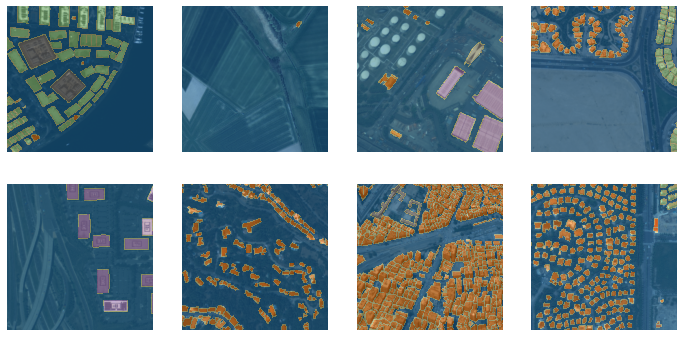

In [6]:
dls.show_batch(max_n=9)
batch = dls.one_batch()

<AxesSubplot:>

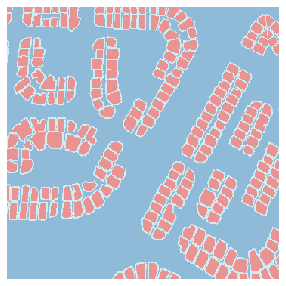

In [7]:
batch[1][1].show()

<AxesSubplot:>

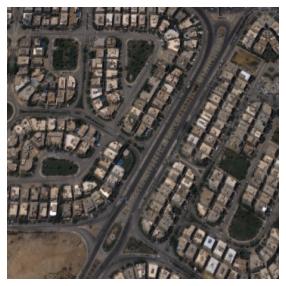

In [8]:
batch[0][1].show()

In [9]:
print(batch[0].size())
print(batch[1].size())

torch.Size([8, 3, 360, 360])
torch.Size([8, 360, 360])


In [10]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.,gamma=3):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis,gamma=gamma)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)



SuggestedLRs(valley=6.815272354288027e-05)

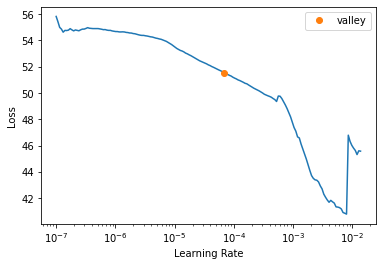

In [11]:
tensorboard_dir = Path().resolve() / 'model1_wz_logs'
if not tensorboard_dir.exists():
    tensorboard_dir.mkdir(parents=True)
cbs = [TensorBoardCallback(log_dir= (tensorboard_dir /  "train_detect_building_no_unfreeze").__str__()),
                           ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
                           EarlyStoppingCallback(monitor='valid_loss')]

learn = unet_learner(dls,resnet34,self_attention=True,
                     loss_func=CombinedLoss(),cbs=cbs)

learn.lr_find(num_it=200,end_lr=8e-2)

In [12]:
%load_ext tensorboard
%tensorboard --logdir model1_logs
notebook.display(height=500)

Reusing TensorBoard on port 6006 (pid 3048), started 0:45:22 ago. (Use '!kill 3048' to kill it.)

Selecting TensorBoard with logdir model1_logs (started 0:45:22 ago; port 6006, pid 3048).


In [13]:
learn.fit_one_cycle(10,4.5e-5)

epoch,train_loss,valid_loss,time
0,49.977463,48.412312,01:12
1,41.572384,31.538893,01:57
2,29.206093,26.868807,01:56
3,23.928520,22.650858,01:39
4,22.888601,22.067137,01:20
5,22.480879,22.262970,01:25


No improvement since epoch 4: early stopping


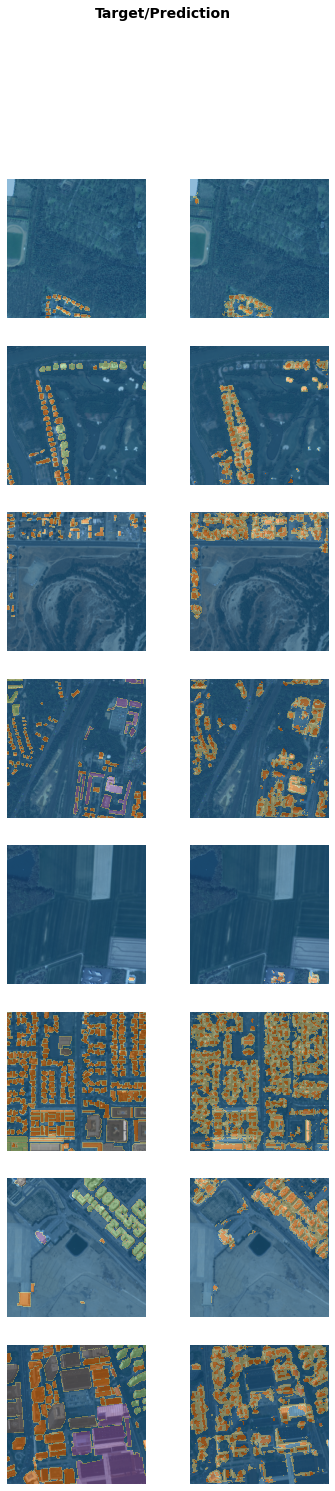

In [14]:
learn.show_results()

In [15]:
model_name = Path().resolve() / 'predict_wz_footprint'
learn.export(model_name)
learn.save(model_name)
try:
    s3 = boto3.client('s3')
    with open(model_name.__str__(), 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".model", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
    with open(model_name.__str__() + '.pth', 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".pth", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
except:
    pass # If you don;t have AWS access then I'm not goign to force you to upload stuff

SuggestedLRs(valley=2.8169708457426168e-05)

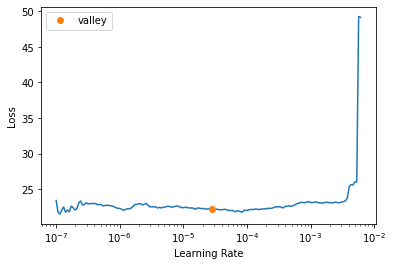

In [16]:
cb_index = [str(x) for x in learn.cbs].index("TensorBoardCallback")
learn.remove_cb(learn.cbs[cb_index])
learn.add_cb(TensorBoardCallback(log_dir= (tensorboard_dir /  "train_detect_building_unfreeze").__str__()))
learn.lr_find(num_it=200,end_lr=8e-2)

epoch,train_loss,valid_loss,time
0,22.466448,21.837523,01:16
1,22.011526,21.761307,01:40
2,22.307484,21.656843,01:38
3,21.774643,21.674679,01:34


No improvement since epoch 2: early stopping


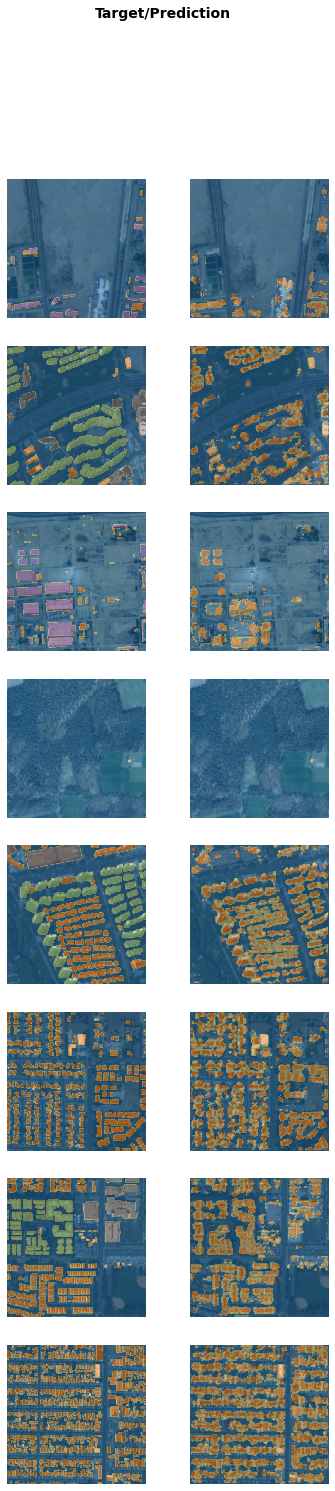

In [17]:
# I have another option of doing add_cbs and remove_cbs, but this is more clear
# learn.cbs= cbs = [TensorBoardCallback(log_dir= (tensorboard_dir /  "train_detect_building_unfreeze").__str__()),
#                            ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
#                            EarlyStoppingCallback(monitor='valid_loss')]

learn.unfreeze()
learn.fit_one_cycle(10,slice(4.5e-9,3e-6))
learn.show_results()

In [22]:
model_name = Path().resolve() / 'predict_wz_footprint_fine_tuned'
learn.export(model_name)
learn.save(model_name)
try:
    s3 = boto3.client('s3')
    with open(model_name.__str__(), 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".model", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
    with open(model_name.__str__() + '.pth', 'rb') as fp:
        s3.upload_fileobj(fp, bucket_name, model_name.name +".pth", ExtraArgs=dict(RequestPayer='requester',
                                                                     ACL='public-read'))
except: pass

In [2]:
from fastai.learner import load_learner
from pathlib import Path

In [4]:
os.getcwd()

'c:\\Users\\thomas\\Desktop\\irdis\\AISpark_Challenge_IRDIS-main\\Module_3'

In [6]:
aftertif = 'inference_data/after/10300100C540A500_-90.021_29.89.tif'
beforetif = 'inference_data/before/105001001E0A3300_-90.021_29.89.tif'
print(os.path.isfile(aftertif))
print(os.path.isfile(beforetif))

model_1_path = "C:\\Users\\thomas\\Desktop\\irdis\\AISpark_Challenge_IRDIS-main\\Module_3\\predict_wz_footprint_fine_tuned"
model_2_path = "predict_damage_unfrozen"

predict_footprint = load_learner(model_1_path)
#predict_damage = load_learner(model_2_path)


True
True


AttributeError: Custom classes or functions exported with your `Learner` are not available in the namespace currently.
Please re-declare or import them before calling `load_learner`:
	Can't get attribute 'label_func' on <module '__main__'>